## Ensemble Model Notebook

---

### Objective:

- Given the chosen sampling rate, extraction interval and selected filtered features, to investigate the potential benefit of an ensemble model.

### Methodology:

- Create 4 models using the following algorithms:
    - Random Forest
    - Gradient Boosting
    - XGBoost
    - LightGBM
    - MLP
- Train each model on the training data
- Take the most predicted class from each model
- Use the majority vote to make the final prediction

#### Findings:

Selected Features after the correlation analysis:


In [254]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score,balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import VotingClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

plt.style.use("seaborn-v0_8-paper")
import seaborn as sns

sns.set_theme(context="paper", font_scale=1)

In [255]:
# set the paths
BASE_DIR = "../../dataset/"

# features
FEATURES_BASE = "../../features/"
FEATURES = FEATURES_BASE + 'raw/'
# FEATURES = FEATURES_BASE + 'balanced/posteriori/'


# Models
MODELS_PATH = "../../models/"
MODELS_RESULTS = MODELS_PATH + "results/"

# report
PAPER = "../../paper/"
IMAGES_PATH = PAPER + "images/"

# HYERPARAMETERS
SEED = 42
INTERVAL = 1

BALANCING_TYPE = "none"
RESULT_NAME = f"results_ensemble_v4_best_features_{BALANCING_TYPE}.csv"
CM_ARTIFACT_NAME = f"confusion_matrix_models_comparison_artifact_recognition_{BALANCING_TYPE}.npy"
CM_DISEASE_NAME = (
    f"confusion_matrix_models_comparison_disease_recognition_{BALANCING_TYPE}.npy"
)

In [256]:
# -----------------------------------------Constants-----------------------------------------
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
interval = INTERVAL  # You need to define INTERVAL somewhere
sample_rates = [4000]
num_feats = {
    "30 MFCC": "28mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "0cqt",
    "40 RMS": "0rms",
    "40 Zero Crossing Rates": "1zcr",
    "40 Spectral Centroid": "0sc",
    "60 Spectral Bandwidth": "0sb",
    "40 Spectral Rolloff": "0sr",
}

COMPLETE_DATA_PRIOR_CORR_NAME = f'full_data_filtered_{INTERVAL}s_4000hz_' + '_'.join(numvalue for _, numvalue in num_feats.items()) + '.npy'
# load the data
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()
n_cols = full_data['train']['X'].shape[1]

### 1st model - Classification of artifacts, normal and abnormal

In [257]:
# ----------------------------------------- Create DataFrame to store results-----------------------------------------
MODELS = {#'Random Forest': RandomForestClassifier(random_state=SEED),
        'XGBoost': XGBClassifier(random_state=SEED),
        'MLP': MLPClassifier(hidden_layer_sizes=(128, 64, 32,), activation='relu', solver='adam', random_state=SEED),
        'CatBoost': CatBoostClassifier(random_state=SEED, verbose=0),
        'LightGBM': LGBMClassifier(random_state=SEED),
        #'AdaBoost': AdaBoostClassifier(random_state=SEED),
        #'SVM': SVC(random_state=SEED),
        'MLP_ultra': MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32,), activation='relu', solver='adam', random_state=SEED),
        'MLP_large': MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32,), activation='relu', solver='adam', random_state=SEED),
        'MLP_small': MLPClassifier(hidden_layer_sizes=(64, 32,), activation='relu', solver='adam', random_state=SEED, max_iter=500),
        'MLP_tiny': MLPClassifier(hidden_layer_sizes=(32, 16,), activation='relu', solver='adam', random_state=SEED, max_iter=500), 
        'MLP_reverse': MLPClassifier(hidden_layer_sizes=(32, 64, 128, 256, 512, 256, 128, 64, 32), activation='relu', solver='adam', random_state=SEED),
        'MLP_bottleneck': MLPClassifier(hidden_layer_sizes=(512, 64, 32,), activation='relu', solver='adam', random_state=SEED),
        'MLP_rollercoaster': MLPClassifier(hidden_layer_sizes=(512, 128, 256, 128, 256, 64, 32), activation='relu', solver='adam', random_state=SEED),
        'MLP_hourglass': MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32, 64, 128, 256, 512), activation='relu', solver='adam', random_state=SEED),
        #'Naive Bayes': GaussianNB(),
        'MLP_pyramid': MLPClassifier(hidden_layer_sizes=(1024, 512, 256, 128, 128, 128, 64, 32), activation='relu', solver='adam', random_state=SEED),
        'MLP_wide': MLPClassifier(hidden_layer_sizes=(1024, 1024), activation='relu', solver='adam', random_state=SEED),
        'MLP_wide_ultra' : MLPClassifier(hidden_layer_sizes=(1024, 1024, 128, 32 ), activation='relu', solver='adam', random_state=SEED),
        'MLP_sparse': MLPClassifier(hidden_layer_sizes=(32, 16, 8), activation='relu', solver='adam', random_state=SEED),
        'MLP_dropout': MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam', random_state=SEED, early_stopping=True, alpha=0.01),
        'MLP_ensemble': VotingClassifier(estimators=[
        ('mlp1', MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam', random_state=SEED)),
        ('mlp2', MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', solver='adam', random_state=SEED)),
        ('mlp3', MLPClassifier(hidden_layer_sizes=(512, 256, 128), activation='relu', solver='adam', random_state=SEED))
        ], voting='soft'),
        'MLP_ensemble2': VotingClassifier(estimators=[
        ('Random Forest', RandomForestClassifier(random_state=SEED)),
        ('MLP_ultra', MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32,), activation='relu', solver='adam', random_state=SEED)),
        ], voting='soft'),
        'MLP Ensemble 3': VotingClassifier(estimators=[
        ('MLP_rollercoaster', MLPClassifier(hidden_layer_sizes=(512, 128, 256, 128, 256, 64, 32), activation='relu', solver='adam', random_state=SEED)),
        ('MLP_large', MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32,), activation='relu', solver='adam', random_state=SEED)),
        ], voting='soft'),
        'MLP Ensemble 4': VotingClassifier(estimators=[
        ('MLP_rollercoaster', MLPClassifier(hidden_layer_sizes=(512, 128, 256, 128, 256, 64, 32), activation='relu', solver='adam', random_state=SEED)),
        ('MLP_large', MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32,), activation='relu', solver='adam', random_state=SEED)),
        ('MLP_ultra', MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32,), activation='relu', solver='adam', random_state=SEED)),
        ], voting='soft'),
        'MLP_ensemble5': VotingClassifier(estimators=[
        ('Random Forest', RandomForestClassifier(random_state=SEED)),
        ('MLP_ultra', MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32,), activation='relu', solver='adam', random_state=SEED)),
        ('MLP_rollercoaster', MLPClassifier(hidden_layer_sizes=(512, 128, 256, 128, 256, 64, 32), activation='relu', solver='adam', random_state=SEED)),
        ], voting='soft'),
        'MLP_ensemble6': VotingClassifier(estimators=[
        ('MLP_rollercoaster', MLPClassifier(hidden_layer_sizes=(512, 128, 256, 128, 256, 64, 32), activation='relu', solver='adam', random_state=SEED)),
        ('MLP_large', MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32,), activation='relu', solver='adam', random_state=SEED)),
        ('MLP_ultra', MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32,), activation='relu', solver='adam', random_state=SEED)),
        ('MLP_wide', MLPClassifier(hidden_layer_sizes=(1024, 1024), activation='relu', solver='adam', random_state=SEED)),

        ], voting='soft'),
        
    }


METRICS = {
    "Test Acc": accuracy_score,
    "Macro F1": f1_score,
    "Balanced Accuracy": balanced_accuracy_score,
}

result_df = pd.DataFrame(columns=list(METRICS.keys()), index=list(MODELS.keys()))
results_df_train = pd.DataFrame(columns=list(METRICS.keys()), index=list(MODELS.keys()))
cm_dict = {}
cm_dict_train = {}

Training XGBoost

Training MLP

Training CatBoost

Training LightGBM

Training MLP_ultra

Training MLP_large

Training MLP_small

Training MLP_tiny

Training MLP_reverse

Training MLP_bottleneck

Training MLP_rollercoaster

Training MLP_hourglass

Training MLP_pyramid

Training MLP_wide

Training MLP_wide_ultra

Training MLP_sparse

Training MLP_dropout

Training MLP_ensemble

Training MLP_ensemble2

Training MLP Ensemble 3

Training MLP Ensemble 4

Training MLP_ensemble5

Training MLP_ensemble6



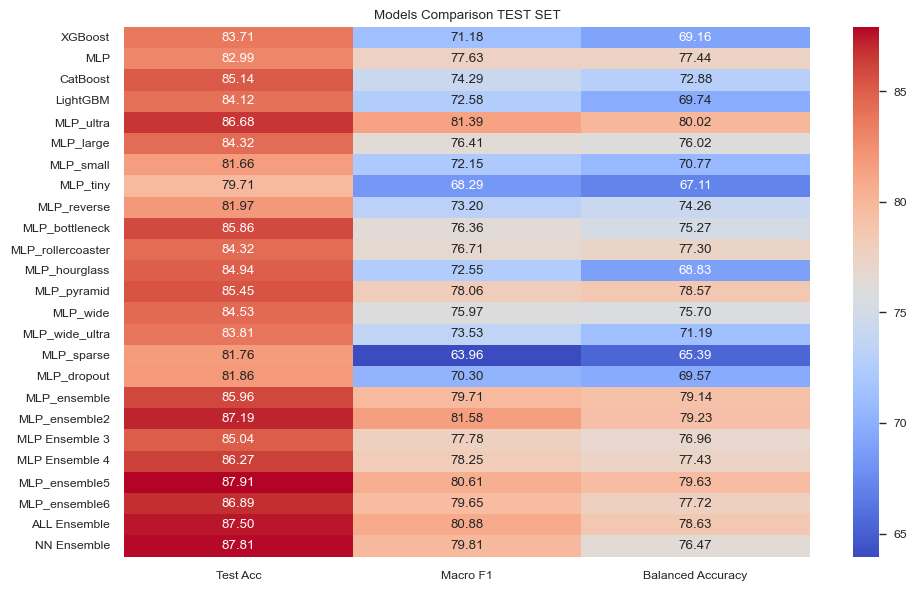

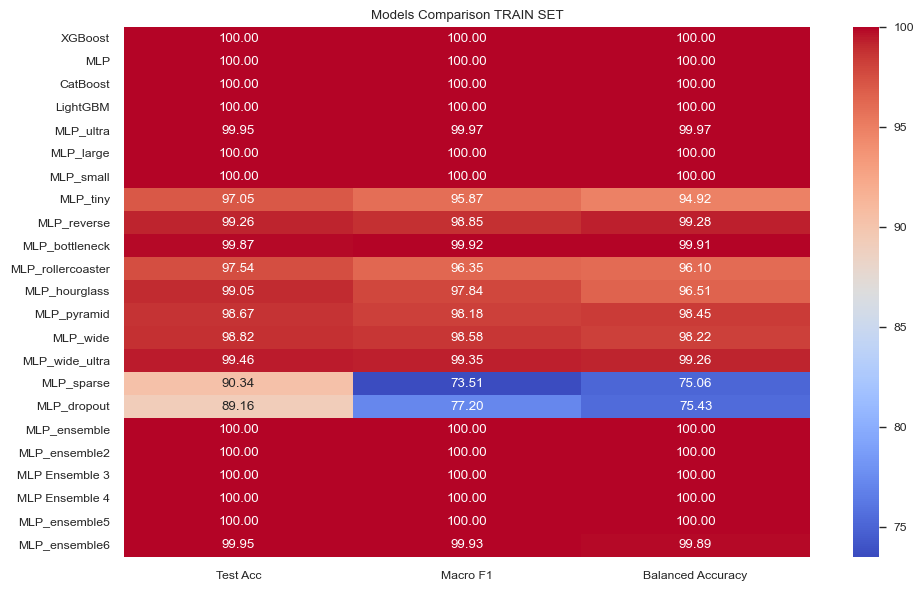

In [258]:
# train each model, store predictions and take the most predicted class as final perdiction
y_pred_all_test = np.zeros((full_data['test']['y'].shape[0], 1))
y_pred_all_train = np.zeros((full_data['train']['y'].shape[0], 1))

for model_name, model in MODELS.items():
	print(f"Training {model_name}\n")
	y_pred_local_test = []
	y_pred_local_train = []
 
	# load the model if it exists
	try:
		model = joblib.load(MODELS_PATH + model_name + f"_{BALANCING_TYPE}.joblib")
	except:
		# train the model
		model.fit(full_data['train']['X'], full_data['train']['y'])
  
		# save the model
		joblib.dump(model, MODELS_PATH + model_name + f"_{BALANCING_TYPE}.joblib")
 
	y_pred_test = model.predict(full_data['test']['X'])
	y_pred_local_test.append(y_pred_test)
 
	y_pred_train = model.predict(full_data['train']['X'])
	y_pred_local_train.append(y_pred_train)
 
	y_true = full_data['test']['y']
	for metric_name, metric in METRICS.items():
		if 'macro' in metric_name.lower():
			result_df.loc[model_name, metric_name] = metric(y_true, y_pred_test, average='macro')
			results_df_train.loc[model_name, metric_name] = metric(full_data['train']['y'], y_pred_train, average='macro')
			
		else:
			result_df.loc[model_name, metric_name] = metric(y_true, y_pred_test)
			results_df_train.loc[model_name, metric_name] = metric(full_data['train']['y'], y_pred_train)

	cm_dict[model_name] = confusion_matrix(y_true, y_pred_test)
	cm_dict_train[model_name] = confusion_matrix(full_data['train']['y'], y_pred_train)
 
	y_pred_all_test = np.hstack([y_pred_all_test, np.vstack(y_pred_local_test).reshape(-1,1)])
	y_pred_all_train = np.hstack([y_pred_all_train, np.vstack(y_pred_local_train).reshape(-1,1)])

# drop the first column
y_pred_all_test = y_pred_all_test[:, 1:]
y_pred_all_train = y_pred_all_train[:, 1:]

# ENSEMBLE MAJORITY VOTING
# take the most predicted class as final perdiction
y_pred_ensemble = []
for row in y_pred_all_test:
    y_pred_ensemble.append(np.argmax(np.bincount(row.astype(int))))
y_pred = np.array(y_pred_ensemble)
y_true = full_data['test']['y']
for metric_name, metric in METRICS.items():
	if 'macro' in metric_name.lower():
		result_df.loc['ALL Ensemble', metric_name] = metric(y_true, y_pred, average='macro')
	else:
		result_df.loc['ALL Ensemble', metric_name] = metric(y_true, y_pred)
cm_dict['ALL Ensemble'] = confusion_matrix(y_true, y_pred)


# ENSEMBLE WITH NEURAL NETWORK
# train a neural network on the predictions of the models
model = CatBoostClassifier(random_state=SEED, verbose=0)
model.fit(y_pred_all_train, full_data['train']['y'])
y_pred = model.predict(y_pred_all_test)
y_true = full_data['test']['y']
for metric_name, metric in METRICS.items():
	if 'macro' in metric_name.lower():
		result_df.loc['NN Ensemble', metric_name] = metric(y_true, y_pred, average='macro')
	else:
		result_df.loc['NN Ensemble', metric_name] = metric(y_true, y_pred)
cm_dict['NN Ensemble'] = confusion_matrix(y_true, y_pred)


# save the results
result_df.to_csv(MODELS_RESULTS + RESULT_NAME)

# plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.heatmap(result_df.astype(float)*100, annot=True, cmap='coolwarm', ax=ax, fmt=".2f")
ax.set_title('Models Comparison TEST SET')
plt.tight_layout()
plt.show()

# plot the training results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.heatmap(results_df_train.astype(float)*100, annot=True, cmap='coolwarm', ax=ax, fmt=".2f")
ax.set_title('Models Comparison TRAIN SET')
plt.tight_layout()
plt.show()

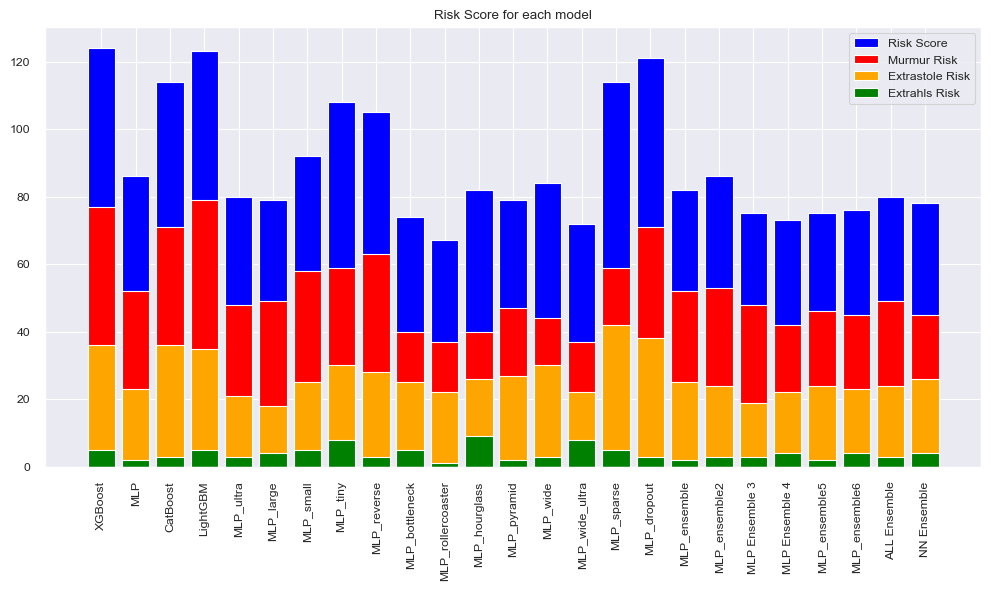

In [259]:
# for all the confusion matrix, take the sum of column 4 minus the cell 4,4
risk_score_list, murmur_risk_list, extrahl_risk_list, extrastole_risk_list = [], [], [], []
for model in cm_dict.keys():
    cm = cm_dict[model]
    risk_score = np.sum(cm[:, 3]) - cm[3, 3] #diseases classified as normal
    risk_score_list.append(risk_score)
    
    # disease 2 (murmurs) classified as normal
    murmur_risk = cm[2, 3]
    murmur_risk_list.append(murmur_risk)
    # disease 1 (extrahls) classified as normal
    extrahl_risk = cm[1, 3]
    extrahl_risk_list.append(extrahl_risk)
    # disease 4 (extrastoles) classified as normal
    extrastole_risk = cm[4, 3]
    extrastole_risk_list.append(extrastole_risk)
    
    
# plot the results in unique bar plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.bar(np.arange(len(risk_score_list)), risk_score_list, label='Risk Score', color='blue')
ax.bar(np.arange(len(murmur_risk_list)), murmur_risk_list, label='Murmur Risk', color='red')
ax.bar(np.arange(len(extrastole_risk_list)), extrastole_risk_list, label='Extrastole Risk', color='orange')
ax.bar(np.arange(len(extrahl_risk_list)), extrahl_risk_list, label='Extrahls Risk', color='green')
ax.set_xticks(np.arange(len(risk_score_list)))
ax.set_xticklabels(list(cm_dict.keys()), rotation=90)
ax.set_title('Risk Score for each model')
ax.legend()
plt.tight_layout()
plt.show()

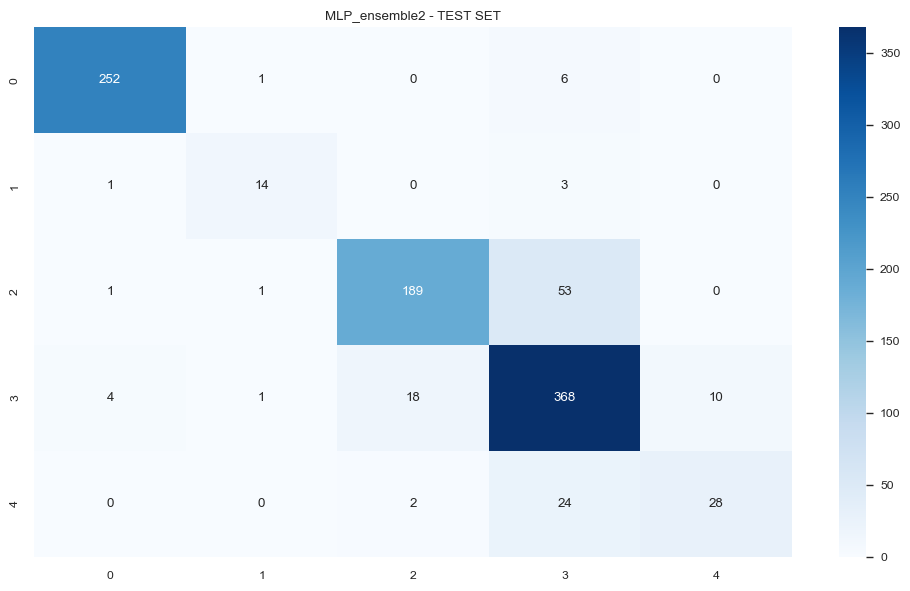

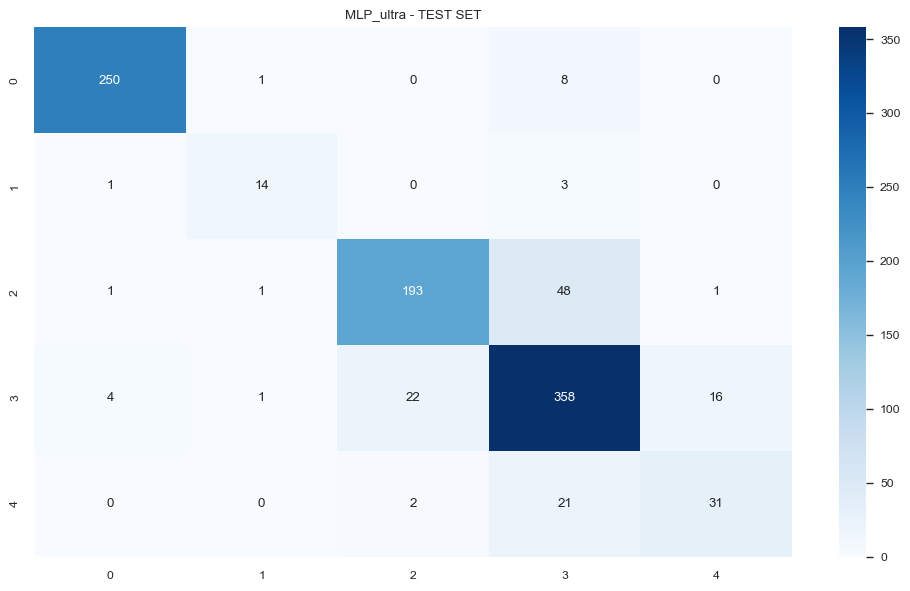

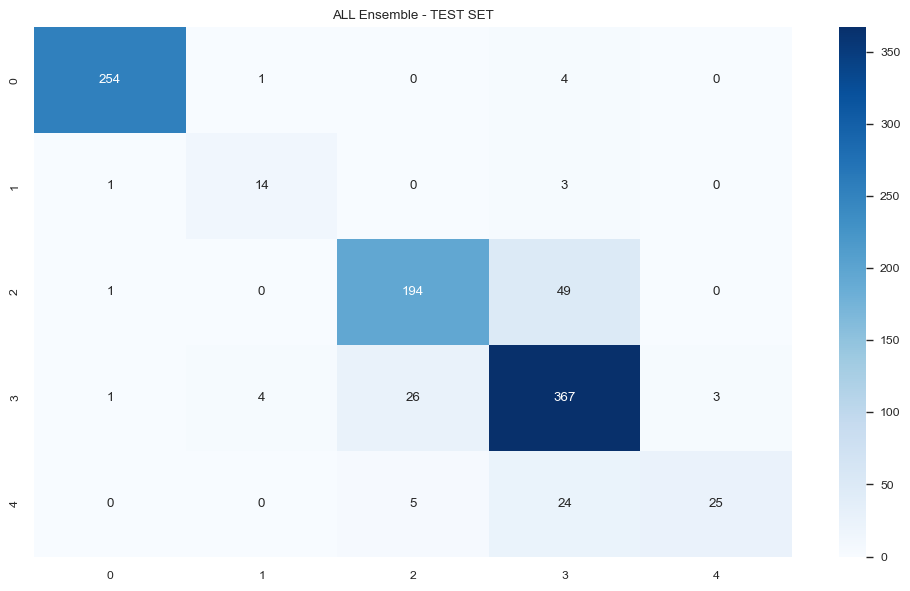

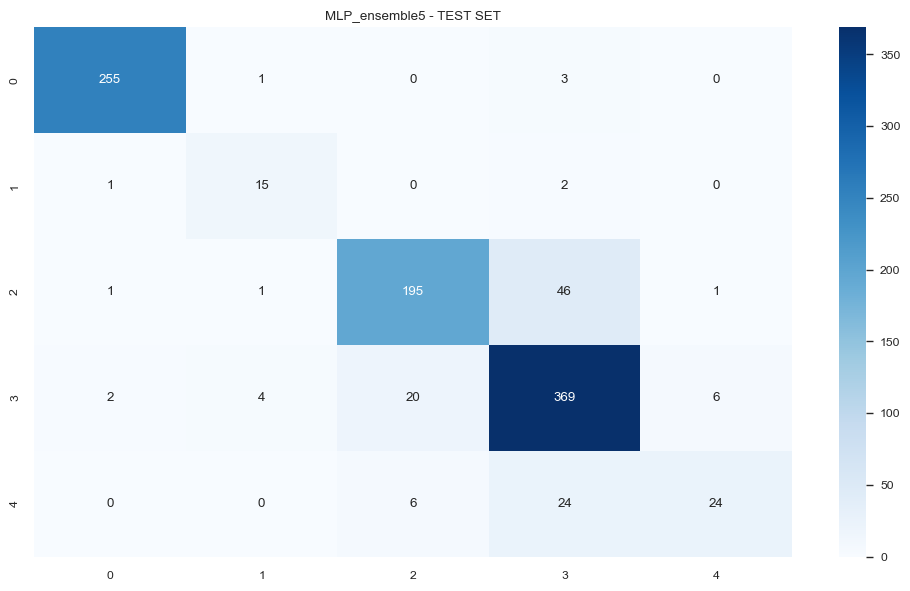

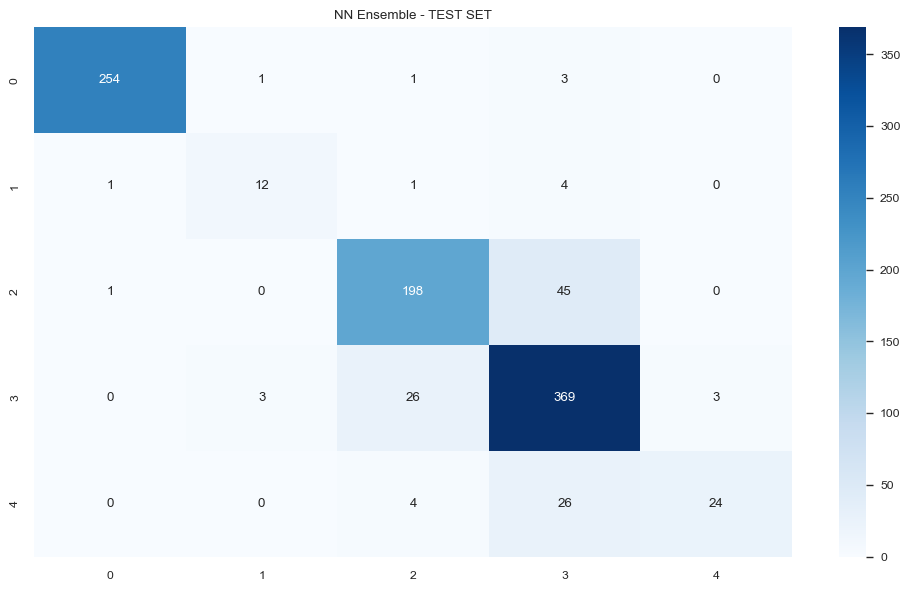

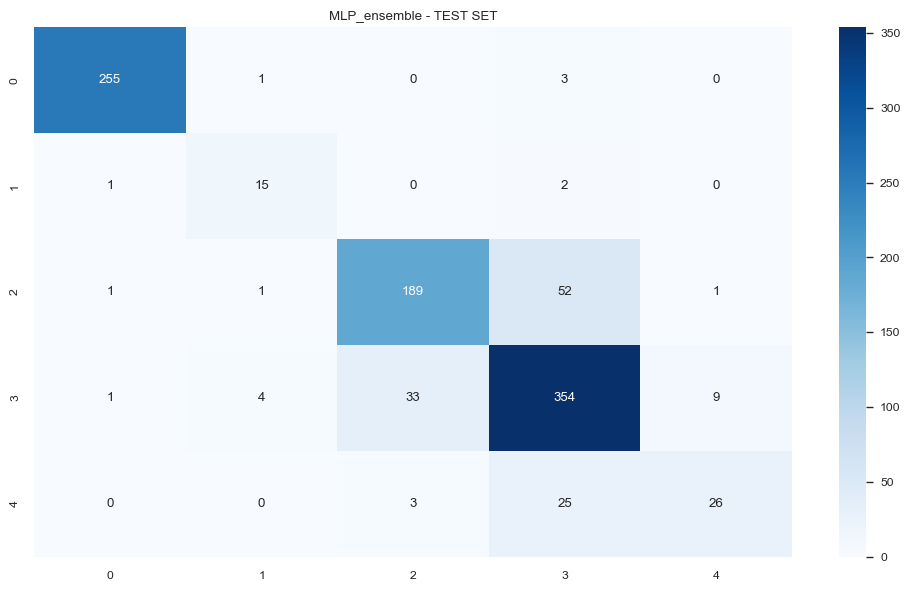

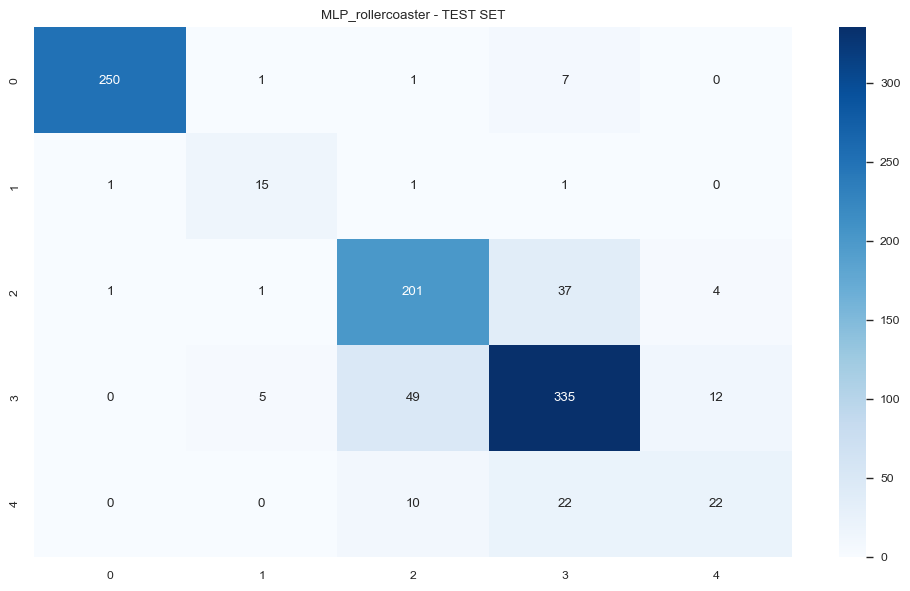

80

In [260]:
# take the best 6 models
best_models = result_df['Macro F1'].sort_values(ascending=False).index[:6]
# add MLP_rollarcoaster
best_models = best_models.append(pd.Index(['MLP_rollercoaster']))

# plot the confusion matrix of the best models
for model_name in best_models:
	fig, ax = plt.subplots(1, 1, figsize=(10, 6))
	sns.heatmap(cm_dict[model_name], annot=True, cmap='Blues', ax=ax, fmt="d")
	ax.set_title(f'{model_name} - TEST SET')
	plt.tight_layout()
	plt.show()
cm_dict['ALL Ensemble'][:,3].sum() - cm_dict['ALL Ensemble'][3,3]

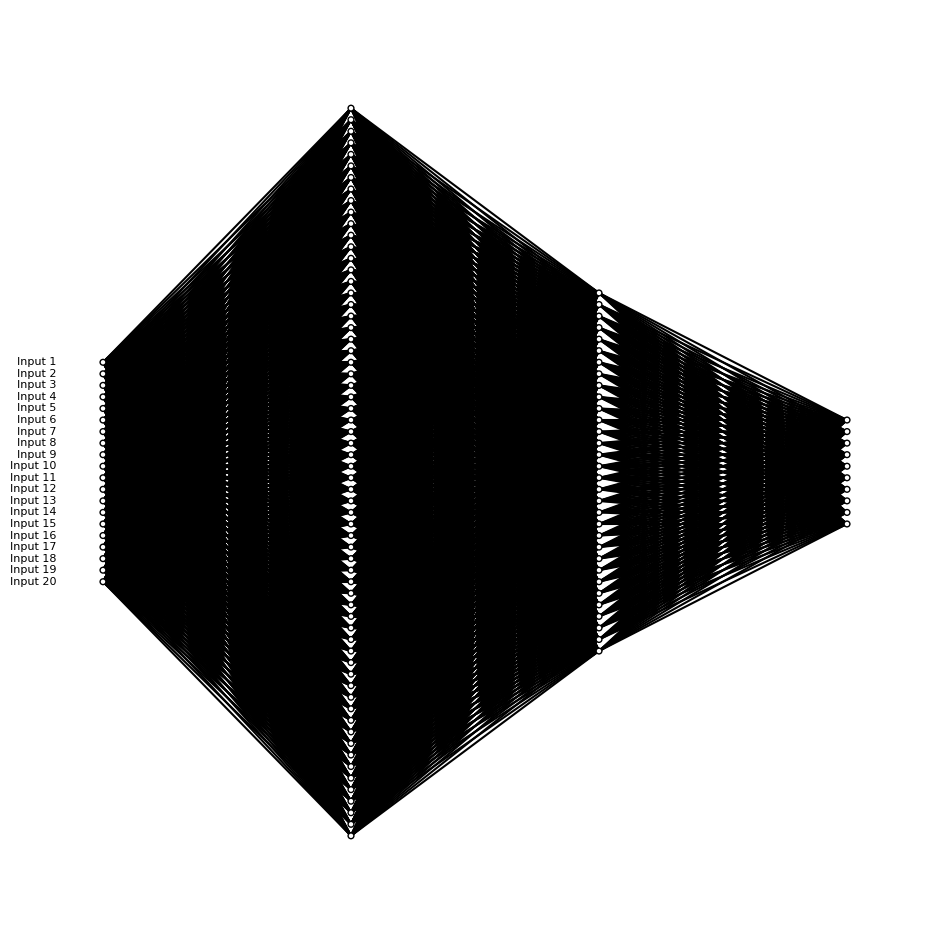

In [3]:
from graphviz import Digraph

def draw_neural_net(layers):
    dot = Digraph()

    # Add nodes for each layer
    for i, layer_size in enumerate(layers):
        with dot.subgraph(name=f'layer_{i}') as s:
            for j in range(layer_size):
                s.node(f'L{i}_{j}', shape='circle')
    
    # Add edges between layers
    for i in range(len(layers) - 1):
        for j in range(layers[i]):
            for k in range(layers[i + 1]):
                dot.edge(f'L{i}_{j}', f'L{i + 1}_{k}')
    
    return dot

# Example usage
layers = [20, 512, 256, 128, 64, 32, 10]  # Define the number of neurons in each layer
dot = draw_neural_net(layers)
dot.render('neural_network', format='png', view=True)
